# Carga y unificación de dataset

In [1]:
import pandas as pd
import glob
import os

# Define the path to the datasets directory
dataset_path = 'datasets'

# Get a list of all CSV files in the directory
csv_files = glob.glob(os.path.join(dataset_path, '*.csv'))

# Load all CSV files into a list of DataFrames
dfs = []
for filename in csv_files:
    df = pd.read_csv(filename)
    dfs.append(df)

# Concatenate all DataFrames into a single DataFrame
if dfs:
    full_df = pd.concat(dfs, ignore_index=True)
    
    # Remove the filename column if it exists
    if 'filename' in full_df.columns:
        full_df = full_df.drop(columns=['filename'])
    
    # Export the unified dataframe to a CSV file
    full_df.to_csv('unified_dataset.csv', index=False)
    print("Unified dataset exported to 'unified_dataset.csv'.")
    
    print("Dataset loaded successfully.")
    print(f"Total rows: {len(full_df)}")
    display(full_df.head())
else:
    print("No CSV files found in the datasets directory.")

Unified dataset exported to 'unified_dataset.csv'.
Dataset loaded successfully.
Total rows: 6000


,person,audio,noise,snr,provider,text,status,transcription_time
0,p7,1,cafe,0dB,custom,Genera una cotización para el cliente con fáci...,success,1.65
1,p7,1,cafe,5dB,custom,Genera una cotización para el cliente con PUC ...,success,1.56
2,p7,1,cafe,10dB,custom,Genera una cotización para el cliente con Puff...,success,1.59
3,p7,1,clean,NaN,custom,Genera una cotización para el cliente con FooF...,success,1.66
4,p7,1,traffic,0dB,custom,"genera una cotización para el cliente fácil, c...",success,1.53


In [2]:
mean_time_by_provider = full_df.groupby('provider')['transcription_time'].mean()
print("Mean Transcription Time by Provider:")
print(mean_time_by_provider)

Mean Transcription Time by Provider:
provider
amazon    12.379000
azure      2.338153
custom     1.380573
google     1.011293
Name: transcription_time, dtype: float64


# Normalización

In [3]:
import sys
import os

# Add the tools directory to the system path
sys.path.append(os.path.abspath('tools'))

from normalize import normalize_text

# Apply normalization to the text column
if 'text' in full_df.columns:
    full_df['text_normalized'] = full_df['text'].apply(normalize_text)
    print("Text column normalized successfully.")
    display(full_df.head(3))
    # full_df.to_csv('normalized_dataset.csv', index=False)
else:
    print("Text column not found in the dataframe.")

Text column normalized successfully.


,person,audio,noise,snr,provider,text,status,transcription_time,text_normalized
0,p7,1,cafe,0dB,custom,Genera una cotización para el cliente con fáci...,success,1.65,genera una cotización para el cliente con fáci...
1,p7,1,cafe,5dB,custom,Genera una cotización para el cliente con PUC ...,success,1.56,genera una cotización para el cliente con puc ...
2,p7,1,cafe,10dB,custom,Genera una cotización para el cliente con Puff...,success,1.59,genera una cotización para el cliente con puff...


In [4]:
filtered_df = full_df.loc[(full_df['person'] == 'p4') & (full_df['noise'] == 'clean') & (full_df['provider'] == 'custom')]
display(filtered_df[['audio','text']].head(3))

,audio,text
5253,1,Genera una cotización para el cliente CompuFac...
5263,2,Prepara un presupuesto urgente con 10 teclados...
5273,3,Crea una oferta comercial para Carla Santana c...


# Cálculo de WER

In [5]:
from wer_utils import calculate_wer_from_dataframe
wer, df_wer = calculate_wer_from_dataframe(full_df, 'ground_truth.json')
print(f"Global WER: {wer}")
df_wer.to_csv('wer_dataset.csv', index=False)

Global WER: 0.06281531531531531


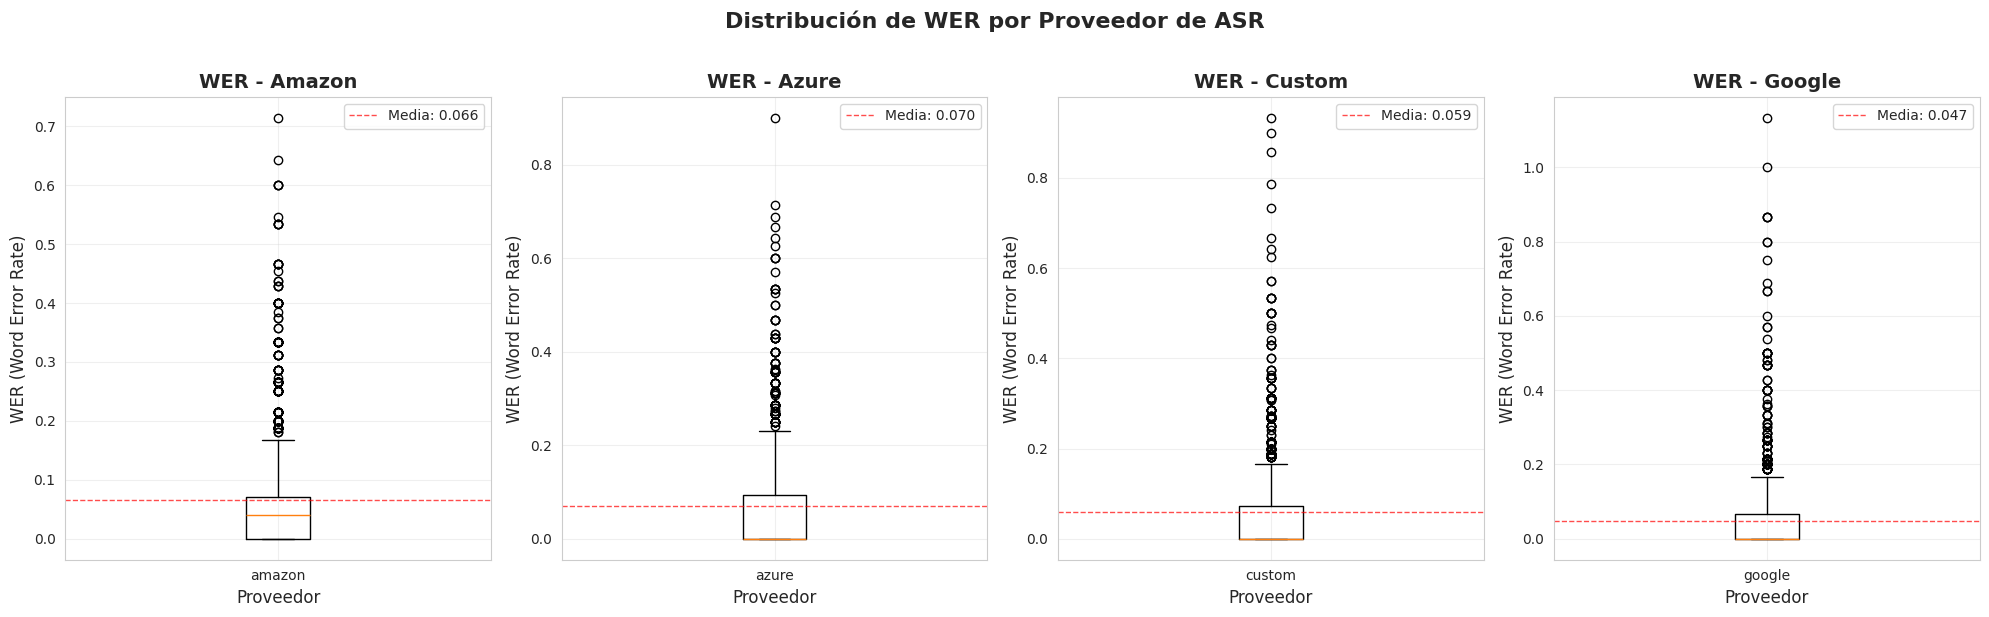


Estadísticas de WER por Proveedor:

AMAZON:
  Media:    0.0662
  Mediana:  0.0400
  Mínimo:   0.0000
  Máximo:   0.7143
  Desv. Est: 0.1004
  Muestras: 1500

AZURE:
  Media:    0.0703
  Mediana:  0.0000
  Mínimo:   0.0000
  Máximo:   0.9000
  Desv. Est: 0.1086
  Muestras: 1500

CUSTOM:
  Media:    0.0590
  Mediana:  0.0000
  Mínimo:   0.0000
  Máximo:   0.9333
  Desv. Est: 0.1085
  Muestras: 1500

GOOGLE:
  Media:    0.0475
  Mediana:  0.0000
  Mínimo:   0.0000
  Máximo:   1.1333
  Desv. Est: 0.1115
  Muestras: 1500


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar el estilo de seaborn para gráficos más atractivos
sns.set_style("whitegrid")

# Obtener la lista de proveedores únicos
providers = df_wer['provider'].unique()

# Crear una figura con subplots para cada proveedor
fig, axes = plt.subplots(1, len(providers), figsize=(5*len(providers), 6))

# Crear un boxplot para cada proveedor
for idx, provider in enumerate(sorted(providers)):
    # Filtrar datos por proveedor
    provider_data = df_wer[df_wer['provider'] == provider]['wer']
    
    # Crear el boxplot
    axes[idx].boxplot(provider_data, tick_labels=[provider])
    axes[idx].set_title(f'WER - {provider.capitalize()}', fontsize=14, fontweight='bold')
    axes[idx].set_ylabel('WER (Word Error Rate)', fontsize=12)
    axes[idx].set_xlabel('Proveedor', fontsize=12)
    axes[idx].grid(True, alpha=0.3)
    
    # Agregar estadísticas básicas
    mean_wer = provider_data.mean()
    median_wer = provider_data.median()
    axes[idx].axhline(y=mean_wer, color='r', linestyle='--', linewidth=1, alpha=0.7, label=f'Media: {mean_wer:.3f}')
    axes[idx].legend()

plt.suptitle('Distribución de WER por Proveedor de ASR', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Mostrar estadísticas descriptivas por proveedor
print("\nEstadísticas de WER por Proveedor:")
for provider in sorted(providers):
    provider_data = df_wer[df_wer['provider'] == provider]['wer']
    print(f"\n{provider.upper()}:")
    print(f"  Media:    {provider_data.mean():.4f}")
    print(f"  Mediana:  {provider_data.median():.4f}")
    print(f"  Mínimo:   {provider_data.min():.4f}")
    print(f"  Máximo:   {provider_data.max():.4f}")
    print(f"  Desv. Est: {provider_data.std():.4f}")
    print(f"  Muestras: {len(provider_data)}")

In [7]:
display(df_wer.sort_values(by='wer', ascending=False).head(5)[['provider','wer']])

,provider,wer
3634,google,1.133333
3647,google,1.000000
2437,custom,0.933333
4797,azure,0.900000
2247,custom,0.900000


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Configurar estilo
sns.set_style("whitegrid")
plt.figure(figsize=(12, 7))

# Definir el orden correcto de los niveles de SNR
snr_order = ['clean','10dB', '5dB', '0dB']

# Preparar los datos: calcular WER promedio por provider y SNR
# Normalizar los valores de SNR para asegurar consistencia
df_wer['snr_normalized'] = df_wer['snr'].astype(str).str.lower().str.replace('db', 'dB')

# Reemplazar 'nan' por 'clean' si es necesario
df_wer.loc[df_wer['snr_normalized'] == 'nan', 'snr_normalized'] = 'clean'

# Agrupar por provider y snr_normalized para calcular el WER correctamente
grouped_wer = df_wer.groupby(['provider', 'snr_normalized']).agg(
    total_errors=('errors', 'sum'),
    total_reference_words=('reference_words', 'sum')
).reset_index()

# Calcular el WER para cada grupo
grouped_wer['wer'] = grouped_wer['total_errors'] / grouped_wer['total_reference_words']

wer_by_provider_snr = grouped_wer[['provider', 'snr_normalized', 'wer']]


# Obtener lista de proveedores únicos
providers = sorted(df_wer['provider'].unique())
print("Providers found:", providers)
display(wer_by_provider_snr)


Providers found: ['amazon', 'azure', 'custom', 'google']


,provider,snr_normalized,wer
0,amazon,0dB,0.114414
1,amazon,10dB,0.043844
2,amazon,5dB,0.055856
3,amazon,clean,0.043694
4,azure,0dB,0.140240
5,azure,10dB,0.037988
6,azure,5dB,0.057958
7,azure,clean,0.022523
8,custom,0dB,0.124474
9,custom,10dB,0.029129


<Figure size 1200x700 with 0 Axes>

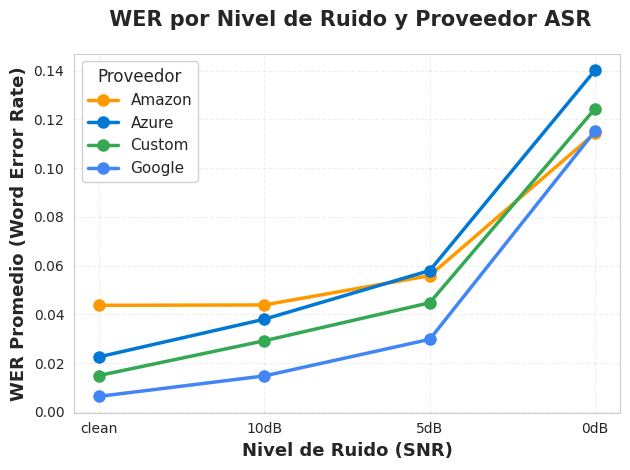


WER Promedio por Proveedor y Nivel de SNR:


provider,amazon,azure,custom,google
snr_normalized,,,,
clean,0.043694,0.022523,0.014865,0.006306
10dB,0.043844,0.037988,0.029129,0.014715
5dB,0.055856,0.057958,0.044745,0.029730
0dB,0.114414,0.140240,0.124474,0.115315




Comparación de Degradación del WER:

AMAZON:
  WER en condiciones limpias (clean): 0.0437
  WER en peor condición (0dB): 0.1144
  Degradación: 161.86%

AZURE:
  WER en condiciones limpias (clean): 0.0225
  WER en peor condición (0dB): 0.1402
  Degradación: 522.67%

CUSTOM:
  WER en condiciones limpias (clean): 0.0149
  WER en peor condición (0dB): 0.1245
  Degradación: 737.37%

GOOGLE:
  WER en condiciones limpias (clean): 0.0063
  WER en peor condición (0dB): 0.1153
  Degradación: 1728.57%


In [9]:

# Definir colores para cada proveedor
colors = {
    'google': '#4285F4',   # Azul Google
    'azure': '#0078D4',    # Azul Azure
    'amazon': '#FF9900',   # Naranja Amazon
    'custom': '#34A853'    # Verde
}

# Crear el gráfico de líneas
for provider in providers:
    # Filtrar datos para este proveedor
    provider_data = wer_by_provider_snr[wer_by_provider_snr['provider'] == provider]
    
    # Crear un DataFrame con todos los niveles de SNR para asegurar continuidad
    provider_full = pd.DataFrame({'snr_normalized': snr_order})
    provider_full = provider_full.merge(provider_data, on='snr_normalized', how='left')
    
    # Graficar la línea
    plt.plot(provider_full['snr_normalized'], 
             provider_full['wer'], 
             marker='o', 
             linewidth=2.5, 
             markersize=8,
             label=provider.capitalize(),
             color=colors.get(provider, None),
             linestyle='-')

# Configurar el gráfico
plt.xlabel('Nivel de Ruido (SNR)', fontsize=13, fontweight='bold')
plt.ylabel('WER Promedio (Word Error Rate)', fontsize=13, fontweight='bold')
plt.title(' WER por Nivel de Ruido y Proveedor ASR', 
          fontsize=15, fontweight='bold', pad=20)

# Configurar leyenda
plt.legend(title='Proveedor', fontsize=11, title_fontsize=12, 
           loc='best', framealpha=0.9)

# Configurar grid
plt.grid(True, alpha=0.3, linestyle='--')

# Ajustar layout
plt.tight_layout()
plt.show()

# Mostrar tabla de datos resumen
print("\nWER Promedio por Proveedor y Nivel de SNR:")
print("="*70)
pivot_table = wer_by_provider_snr.pivot(index='snr_normalized', 
                                         columns='provider', 
                                         values='wer')
# Reordenar las filas según snr_order
pivot_table = pivot_table.reindex([snr for snr in snr_order if snr in pivot_table.index])
display(pivot_table)

# Mostrar estadísticas adicionales
print("\n\nComparación de Degradación del WER:")
for provider in providers:
    provider_data = wer_by_provider_snr[wer_by_provider_snr['provider'] == provider]
    provider_data = provider_data.set_index('snr_normalized').reindex(snr_order)
    
    if 'clean' in provider_data.index and not pd.isna(provider_data.loc['clean', 'wer']):
        clean_wer = provider_data.loc['clean', 'wer']
        print(f"\n{provider.upper()}:")
        print(f"  WER en condiciones limpias (clean): {clean_wer:.4f}")
        
        if '0dB' in provider_data.index and not pd.isna(provider_data.loc['0dB', 'wer']):
            worst_wer = provider_data.loc['0dB', 'wer']
            degradation = ((worst_wer - clean_wer) / clean_wer) * 100
            print(f"  WER en peor condición (0dB): {worst_wer:.4f}")
            print(f"  Degradación: {degradation:.2f}%")

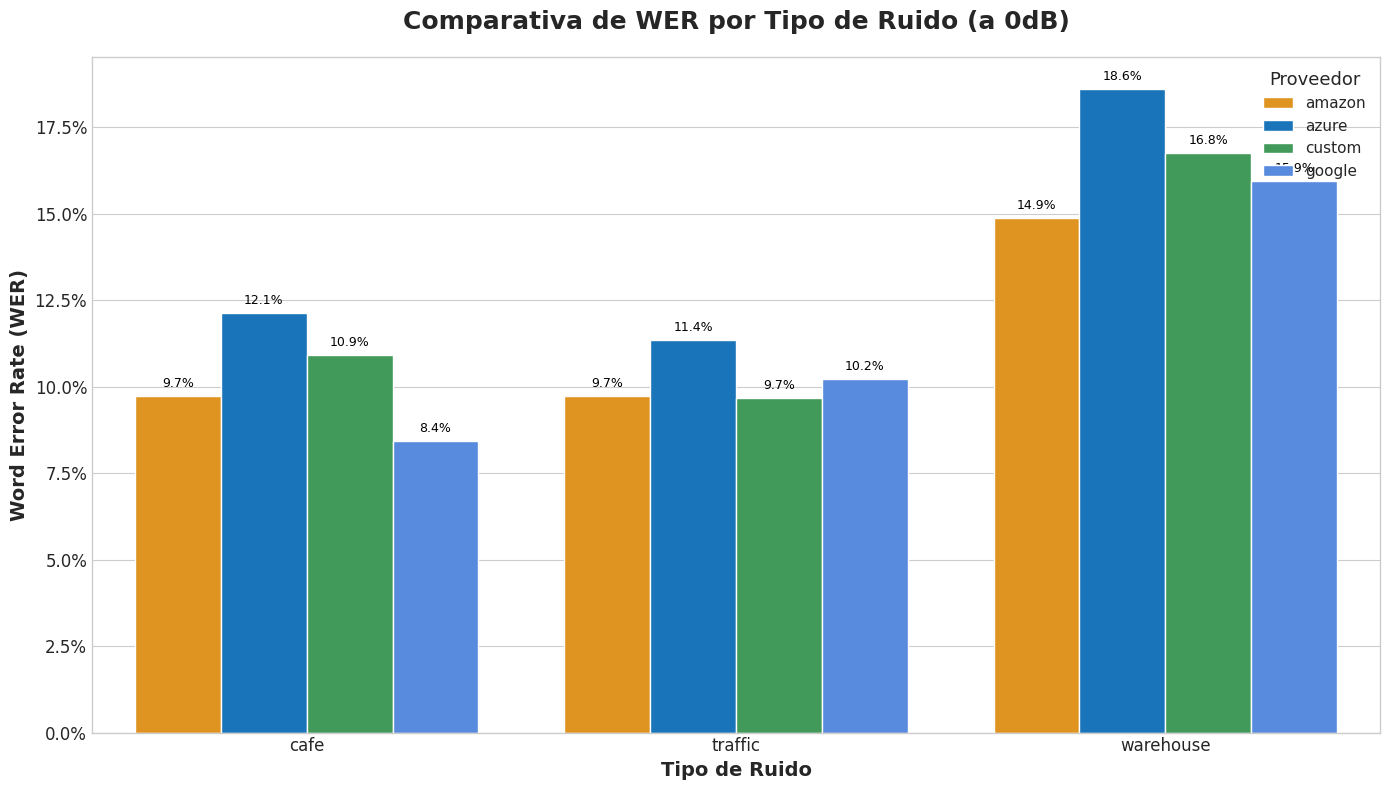

Datos de WER a 0dB por Tipo de Ruido y Proveedor:


,noise,provider,wer
3,cafe,google,0.084234
0,cafe,amazon,0.097297
2,cafe,custom,0.109009
1,cafe,azure,0.121171
6,traffic,custom,0.096847
4,traffic,amazon,0.097297
7,traffic,google,0.102252
5,traffic,azure,0.113514
8,warehouse,amazon,0.148649
11,warehouse,google,0.159459


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import PercentFormatter

# 1. Filtrar los datos para el nivel de ruido más bajo (0dB)
df_0db = df_wer[df_wer['snr_normalized'] == '0dB'].copy()

# 2. Calcular el WER agregado por tipo de ruido y proveedor
# Es crucial volver a calcular el WER para los grupos, no promediar el WER de las filas.
wer_by_noise = df_0db.groupby(['noise', 'provider']).agg(
    total_errors=('errors', 'sum'),
    total_reference_words=('reference_words', 'sum')
).reset_index()

# Calcular el WER correcto para cada grupo
wer_by_noise['wer'] = (wer_by_noise['total_errors'] / wer_by_noise['total_reference_words'])

# 3. Crear el gráfico de barras agrupadas
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(14, 8))

sns.barplot(data=wer_by_noise, x='noise', y='wer', hue='provider', ax=ax,
            palette={'google': '#4285F4', 'azure': '#0078D4', 'amazon': '#FF9900', 'custom': '#34A853'})

# 4. Formatear y embellecer el gráfico
ax.set_title('Comparativa de WER por Tipo de Ruido (a 0dB)', fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Tipo de Ruido', fontsize=14, fontweight='bold')
ax.set_ylabel('Word Error Rate (WER)', fontsize=14, fontweight='bold')

# Formatear el eje Y como porcentaje
ax.yaxis.set_major_formatter(PercentFormatter(1.0))

# Ajustar la leyenda
ax.legend(title='Proveedor', title_fontsize='13', fontsize='11', loc='upper right')

# Mejorar la legibilidad de las etiquetas del eje X
plt.xticks(rotation=0, ha='center', fontsize=12)
plt.yticks(fontsize=12)

# Añadir valores en la parte superior de cada barra para mayor claridad
for p in ax.patches:
    # Solo anotar si la barra tiene una altura mayor a cero para evitar artefactos
    if p.get_height() > 0:
        ax.annotate(f'{p.get_height():.1%}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    xytext=(0, 9), 
                    textcoords='offset points',
                    fontsize=9,
                    color='black')

plt.tight_layout()
plt.show()

# Opcional: Mostrar la tabla de datos utilizada para el gráfico
print("Datos de WER a 0dB por Tipo de Ruido y Proveedor:")
display(wer_by_noise[['noise', 'provider', 'wer']].sort_values(by=['noise', 'wer']))

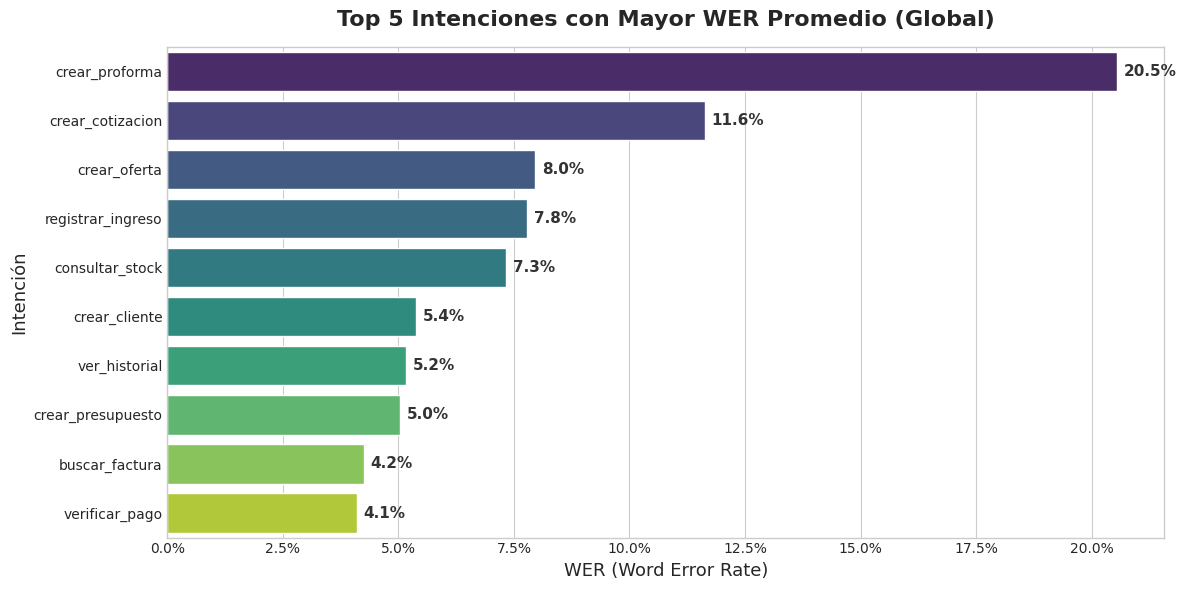

Intenciones con Mayor WER:


,intent,wer,total_errors,total_reference_words
7,crear_proforma,0.205500,1233.0,6000.0
4,crear_cotizacion,0.116250,744.0,6400.0
5,crear_oferta,0.079500,477.0,6000.0
10,registrar_ingreso,0.077857,436.0,5600.0
2,consultar_stock,0.073214,410.0,5600.0
3,crear_cliente,0.053800,538.0,10000.0
13,ver_historial,0.051607,289.0,5600.0
6,crear_presupuesto,0.050313,322.0,6400.0
0,buscar_factura,0.042500,238.0,5600.0
14,verificar_pago,0.040921,311.0,7600.0


In [20]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter

# 1. Cargar reglas de NLU para obtener las intenciones
with open('tools/nlu_rules.json', 'r', encoding='utf-8') as f:
    nlu_rules = json.load(f)

# Crear mapeo de audio_id -> intent
id_to_intent = {str(k): v['intent'] for k, v in nlu_rules.items()}

# 2. Asignar intención al dataframe de WER
# Usamos una copia para no afectar el dataframe original globalmente
df_intent_analysis = df_wer.copy()
df_intent_analysis['intent'] = df_intent_analysis['audio'].astype(str).map(id_to_intent)

# 3. Calcular WER Global por Intención
# Agrupar por intención y sumar errores y palabras de referencia
wer_by_intent = df_intent_analysis.groupby('intent').agg(
    total_errors=('errors', 'sum'),
    total_reference_words=('reference_words', 'sum')
).reset_index()

# Calcular WER: total_errors / total_reference_words
wer_by_intent['wer'] = wer_by_intent['total_errors'] / wer_by_intent['total_reference_words']

# 4. Filtrar Top 5 Intenciones con Mayor WER
top_5_intents = wer_by_intent.sort_values(by='wer', ascending=False).head(10)

# 5. Graficar
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Crear gráfico de barras horizontal
# Se asigna 'intent' a 'hue' y se desactiva la leyenda para evitar el warning de deprecación
ax = sns.barplot(data=top_5_intents, x='wer', y='intent', hue='intent', palette='viridis', legend=False)

# Configurar títulos y ejes
ax.set_title('Top 5 Intenciones con Mayor WER Promedio (Global)', fontsize=16, fontweight='bold', pad=15)
ax.set_xlabel('WER (Word Error Rate)', fontsize=13)
ax.set_ylabel('Intención', fontsize=13)

# Formatear eje X como porcentaje
ax.xaxis.set_major_formatter(PercentFormatter(1.0))

# Añadir etiquetas de valor al final de las barras
for p in ax.patches:
    width = p.get_width()
    if width > 0:
        ax.annotate(f'{width:.1%}', 
                    (width, p.get_y() + p.get_height() / 2.), 
                    ha='left', va='center', 
                    xytext=(5, 0), 
                    textcoords='offset points',
                    fontsize=11, fontweight='bold', color='#333333')

# Ajustar márgenes
plt.tight_layout()
plt.show()

# Mostrar tabla resumen
print("Intenciones con Mayor WER:")
display(top_5_intents[['intent', 'wer', 'total_errors', 'total_reference_words']])

In [21]:
import pandas as pd

# 1. Preparar datos (Recalculando para asegurar disponibilidad en esta celda)
# Agrupar por provider y snr_normalized
ranking_grouped = df_wer.groupby(['provider', 'snr_normalized']).agg(
    total_errors=('errors', 'sum'),
    total_reference_words=('reference_words', 'sum')
).reset_index()

# Calcular WER Global
ranking_grouped['wer'] = ranking_grouped['total_errors'] / ranking_grouped['total_reference_words']

# 2. Definir orden y etiquetas de escenarios
snr_order = ['clean', '10dB', '5dB', '0dB']
scenario_labels = {
    'clean': 'Silencio (Clean)',
    '10dB': 'Ruido Moderado (10dB)',
    '5dB': 'Ruido Alto (5dB)',
    '0dB': 'Ruido Extremo (0dB)'
}

# 3. Construir el ranking
ranking_rows = []

for snr in snr_order:
    # Filtrar y ordenar por WER ascendente (menor es mejor)
    subset = ranking_grouped[ranking_grouped['snr_normalized'] == snr].sort_values(by='wer')
    
    if not subset.empty:
        # Mejor motor (Top 1)
        best = subset.iloc[0]
        best_str = f"{best['provider'].capitalize()} (~{best['wer']:.1%})"
        
        # Motor alterno (Top 2)
        if len(subset) > 1:
            alt = subset.iloc[1]
            alt_str = f"{alt['provider'].capitalize()} (~{alt['wer']:.1%})"
        else:
            alt_str = "-"
            
        ranking_rows.append({
            'Escenario': scenario_labels.get(snr, snr),
            'Mejor Motor': best_str,
            'Motor Alterno': alt_str
        })

# 4. Crear DataFrame y mostrar
df_ranking = pd.DataFrame(ranking_rows)

print("Tabla de Ranking: Mejor Motor vs Alterno por Escenario")
# Estilizar la tabla para mejor visualización
display(df_ranking.style.hide(axis='index').set_properties(**{
    'text-align': 'left',
    'font-size': '12pt',
    'padding': '8px'
}).set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'left'), ('font-size', '12pt'), ('font-weight', 'bold')]}
]))

Tabla de Ranking: Mejor Motor vs Alterno por Escenario


Escenario,Mejor Motor,Motor Alterno
Silencio (Clean),Google (~0.6%),Custom (~1.5%)
Ruido Moderado (10dB),Google (~1.5%),Custom (~2.9%)
Ruido Alto (5dB),Google (~3.0%),Custom (~4.5%)
Ruido Extremo (0dB),Amazon (~11.4%),Google (~11.5%)


# Métricas NLU

In [10]:
from tools.nlu_utils import NLUEvaluator

# Initialize the evaluator
nlu_evaluator = NLUEvaluator()

df_nlu = nlu_evaluator.evaluate_dataset(df_wer)

# Display results
print("NLU Evaluation Completed.")
display(df_nlu[['audio', 'provider', 'text_normalized', 'intent_success', 'slots_success', 'nlu_success']].head())

# Calculate metrics
nlu_metrics = df_nlu.groupby('provider')[['intent_success', 'slots_success', 'nlu_success']].mean()
print("\nNLU Metrics by Provider:")
display(nlu_metrics)


NLU Evaluation Completed.


,audio,provider,text_normalized,intent_success,slots_success,nlu_success
0,1,custom,genera una cotización para el cliente con fáci...,True,False,False
1,1,custom,genera una cotización para el cliente con puc ...,True,False,False
2,1,custom,genera una cotización para el cliente con puff...,True,False,False
3,1,custom,genera una cotización para el cliente con foof...,True,False,False
4,1,custom,genera una cotización para el cliente fácil co...,True,False,False



NLU Metrics by Provider:


,intent_success,slots_success,nlu_success
provider,,,
amazon,0.953333,0.803333,0.768000
azure,0.950667,0.852667,0.817333
custom,0.953333,0.858000,0.826667
google,0.960000,0.866667,0.845333


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

def graficar_matriz_confusion(df_resultados, titulo="Matriz de Confusión"):
    """
    Genera y visualiza la matriz de confusión de intenciones.
    
    Args:
        df_resultados: DataFrame con columnas 'intent_expected' y 'intent_predicted'.
        titulo: String para el título del gráfico (ej: "Google - Ruido 0dB").
    """
    
    # 1. Definir las etiquetas (Clases)
    # Obtenemos todas las intenciones posibles (incluyendo "no_match" si existe)
    y_real = df_resultados['intent_expected']
    y_pred = df_resultados['intent_predicted']
    
    etiquetas = sorted(list(set(y_real.unique()) | set(y_pred.unique())))
    
    # 2. Calcular la Matriz
    cm = confusion_matrix(y_real, y_pred, labels=etiquetas)
    
    # 3. Configurar el Gráfico (Heatmap)
    plt.figure(figsize=(12, 10)) # Tamaño grande para que se lean las etiquetas
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=etiquetas, yticklabels=etiquetas)
    
    # 4. Estética
    plt.title(titulo, fontsize=16, pad=20)
    plt.xlabel('Lo que PREDIJO el sistema', fontsize=12)
    plt.ylabel('Lo que ERA en realidad (Ground Truth)', fontsize=12)
    plt.xticks(rotation=45, ha='right') # Rotar etiquetas de abajo para leerlas bien
    plt.yticks(rotation=0)
    
    # Ajustar márgenes para que no se corte el texto
    plt.tight_layout()
    
    return plt

In [ ]:
df_google = df_nlu[(df_nlu['snr_normalized'] == '0dB') & (df_nlu['provider'] == 'google')]
graficar_matriz_confusion(df_google, "Google Cloud - Ruido Cafetería (10dB)")
plt.show()

In [ ]:
df_nlu.to_csv('nlu_dataset.csv', index=False)